# System Identification in Frequency Domain

In [1]:
import os
import pywt
import itertools
import numpy as np
from numpy.linalg import norm
import pandas as pd
from scipy.fftpack import fft
from scipy.signal import welch
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.core.debugger import set_trace

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from scipy.io import loadmat
import seaborn as sns
from math import floor

# Loading The Dataset (Trial by Trial)

In [2]:
# Get the participant data from Dataset directory
num_eeg_ch = 14
num_emg_ch = 4
num_force_ch = 3
num_conds = 18
file = loadmat('YZ1200Hz.mat')
data = pd.DataFrame(columns=['EEG-1','EEG-2','EEG-3','EEG-4','EEG-5',
                             'EEG-6','EEG-7','EEG-8','EEG-9','EEG-10',
                             'EEG-11','EEG-12','EEG-13','EEG-14','EMG-1',
                             'EMG-2','EMG-3','EMG-4','Force-x', 
                             'Force-y','Force-z'])
temp1 = data.copy()
# for cond in range(num_conds):
cond = 0
for ch in range(num_eeg_ch):
    temp1.iloc[:,ch] = file['EEGSeg_Ch'][0,ch][0,cond].flatten()
for ch in range(num_emg_ch):
    temp1.iloc[:,ch+num_eeg_ch] = file['EMGSeg_Ch'][0,ch][0,cond].flatten()
for ch in range(num_force_ch):
    temp1.iloc[:,ch+num_eeg_ch+num_emg_ch] = file['ForceSeg_Ch'][0,ch][0,cond].flatten()
data = data.append(temp1, ignore_index=True)
del temp1

num_trials = file['EEGSeg_Ch'][0,0][0,cond].shape[0]
num_samples_per_trial = file['EEGSeg_Ch'][0,0][0,cond].shape[1]

data_splitBy_trials = np.array_split(data, num_trials)
# mean subtraction in each trial from the eeg columns
# for subtracting dc shift
for trial in range(num_trials):
    data_splitBy_trials[trial].iloc[:,:] -= data_splitBy_trials[trial].iloc[:,:].mean()
    # convert volts to microvolts for EEG and EMG channels
    data_splitBy_trials[trial].values[:,:18] *= 1e6
    # convert volts to milivolts for force channels
    data_splitBy_trials[trial].values[:,18:] *= 1e3    

In [3]:
t0=0
fs=1200
dt=1.0/fs
time = (np.arange(0, num_samples_per_trial) * dt + t0) * 1e3
# pick one channel from eeg, emg and force
eeg_signal_1 = data_splitBy_trials[0].iloc[:,0] # trial 1, eeg_ch1
emg_signal_1 = data_splitBy_trials[0].iloc[:,14] # trial 1, emg_ch1
force_signal_3 = data_splitBy_trials[0].iloc[:,20] # trial 1, force_ch3

# Visualization of The Dataset

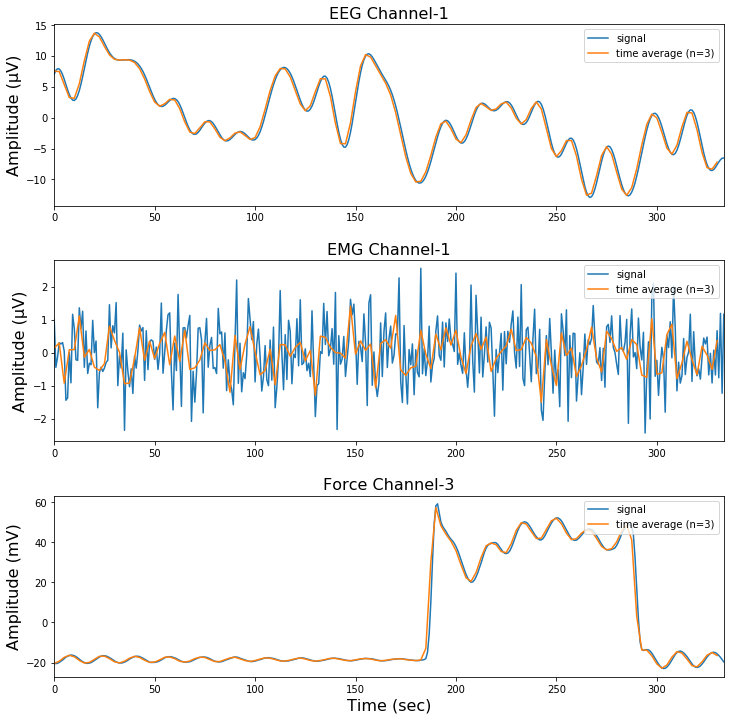

In [4]:
def get_ave_values(xvalues, yvalues, n):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(average_over))
    ax.set_xlim([time[0], time[-1]])
    ax.legend(loc='upper right')

fig, axes = plt.subplots(3, figsize=(12,12))
fig.subplots_adjust(hspace=0.3)
plot_signal_plus_average(axes[0], time, eeg_signal_1, average_over=3)

axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[0].set_title('EEG Channel-1', fontsize=16)
plot_signal_plus_average(axes[1], time, emg_signal_1, average_over=3)

axes[1].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_title('EMG Channel-1', fontsize=16)
plot_signal_plus_average(axes[2], time, force_signal_3, average_over=3)

axes[2].set_ylabel('Amplitude (mV)', fontsize=16)
axes[2].set_xlabel('Time (sec)', fontsize=16)
axes[2].set_title('Force Channel-3', fontsize=16)

plt.show()

# Fourier Transform of The Data

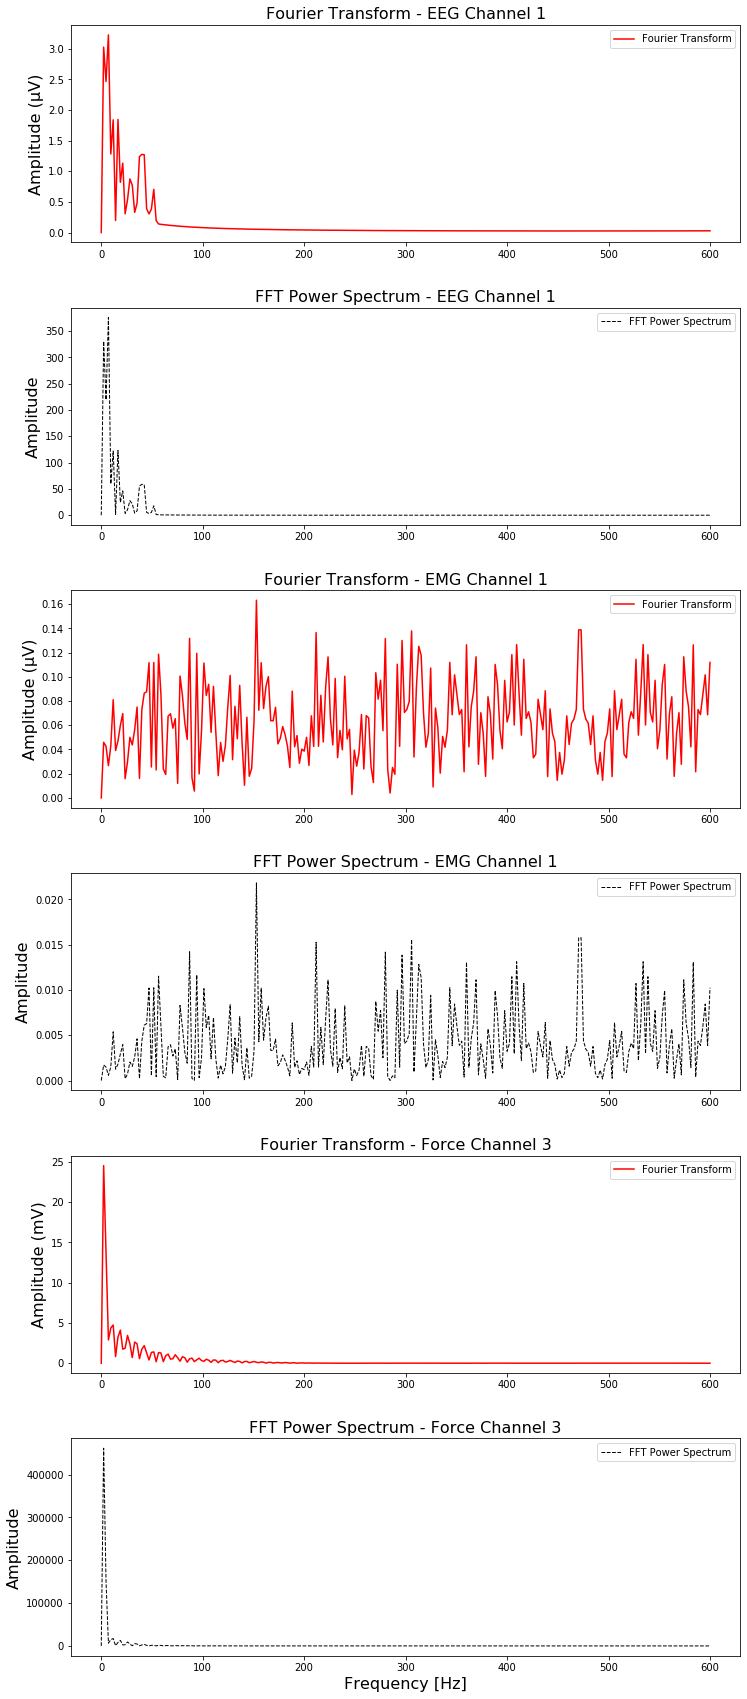

In [5]:
def get_fft_values(y_values, T, N, f_s):
    N2 = 2 ** (int(np.log2(N)) + 1) # round up to next highest power of 2
    f_values = np.linspace(0.0, 1.0/(2.0*T), N2//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N2 * np.abs(fft_values_[0:N2//2])
    return f_values, fft_values

def plot_fft_plus_power(axes, time, signal, fs=fs, dt=dt, N=num_samples_per_trial,
                        plot_direction='horizontal', yticks=None, ylim=None):
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2

    if plot_direction == 'horizontal':
        axes[0].plot(f_values, fft_values, 'r-', label='Fourier Transform')
        axes[1].plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        axes[0].plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        axes[1].plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        axes[0].set_yticks(np.log2(yticks))
        axes[0].set_yticklabels(yticks)
        axes[0].invert_yaxis()
        axes[0].set_ylim(ylim[0], -1)
    axes[0].legend()
    axes[1].legend()

fig, axes = plt.subplots(6, figsize=(12,30))
fig.subplots_adjust(hspace=0.3)
axes[0].set_title('Fourier Transform - EEG Channel 1', fontsize=16)
axes[1].set_title('FFT Power Spectrum - EEG Channel 1', fontsize=16)
axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[0], axes[1]], time, eeg_signal_1)

axes[2].set_title('Fourier Transform - EMG Channel 1', fontsize=16)
axes[3].set_title('FFT Power Spectrum - EMG Channel 1', fontsize=16)
axes[2].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[3].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[2], axes[3]], time, emg_signal_1)

axes[4].set_title('Fourier Transform - Force Channel 3', fontsize=16)
axes[5].set_title('FFT Power Spectrum - Force Channel 3', fontsize=16)
axes[4].set_ylabel('Amplitude (mV)', fontsize=16)
axes[5].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[4], axes[5]], time, force_signal_3)
axes[5].set_xlabel('Frequency [Hz]', fontsize=16)

plt.show()

# Estimation of The Power Spectral Density Using Welch’s Method

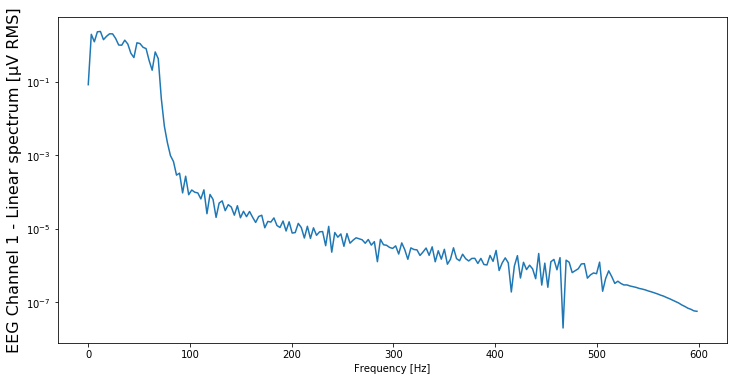

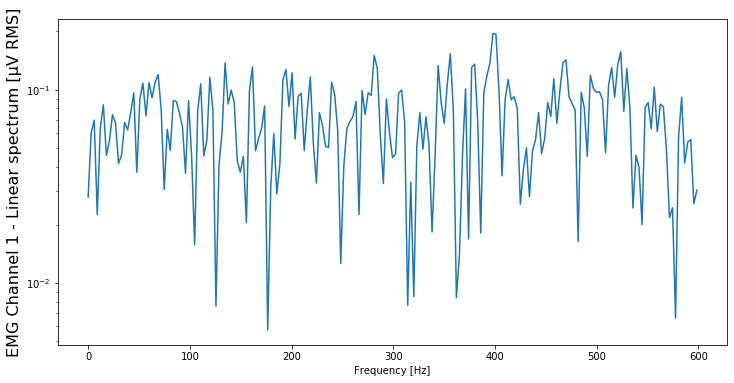

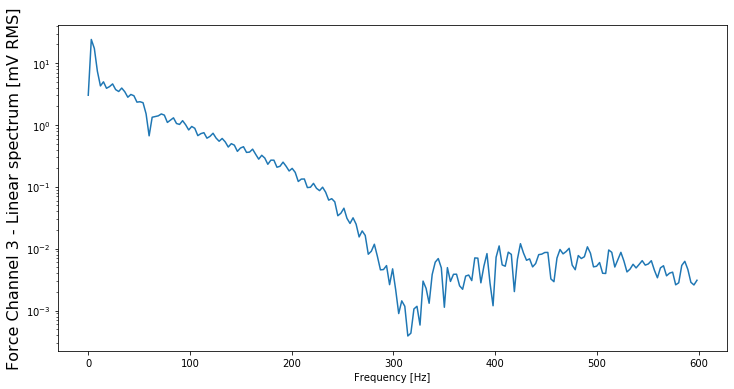

In [6]:
# Welch’s method computes an estimate of the power spectral density by dividing the data
# into overlapping segments, computing a modified periodogram for each segment 
# and averaging the periodograms.

# For the default ‘hanning’ window an overlap of 50% is a reasonable trade off 
# between accurately estimating the signal power, while not over counting any of the data. 
# Narrower windows may require a larger overlap.
for counter, x in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    f, Pxx_spec = welch(x, fs, 'hanning', num_samples_per_trial, scaling='spectrum')
    plt.figure(figsize=(12,6))    
    plt.semilogy(f, np.sqrt(Pxx_spec))
    plt.xlabel('Frequency [Hz]')
    if counter == 0:
        plt.ylabel('EEG Channel 1 - Linear spectrum [\u03bcV RMS]', fontsize=16)
    elif counter == 1:
        plt.ylabel('EMG Channel 1 - Linear spectrum [\u03bcV RMS]', fontsize=16)
    else:
        plt.ylabel('Force Channel 3 - Linear spectrum [mV RMS]', fontsize=16)
    plt.show()
    
# The peak height in the power spectrum is an estimate of the RMS amplitude.

# Discrete Wavelet Transform Coefficients

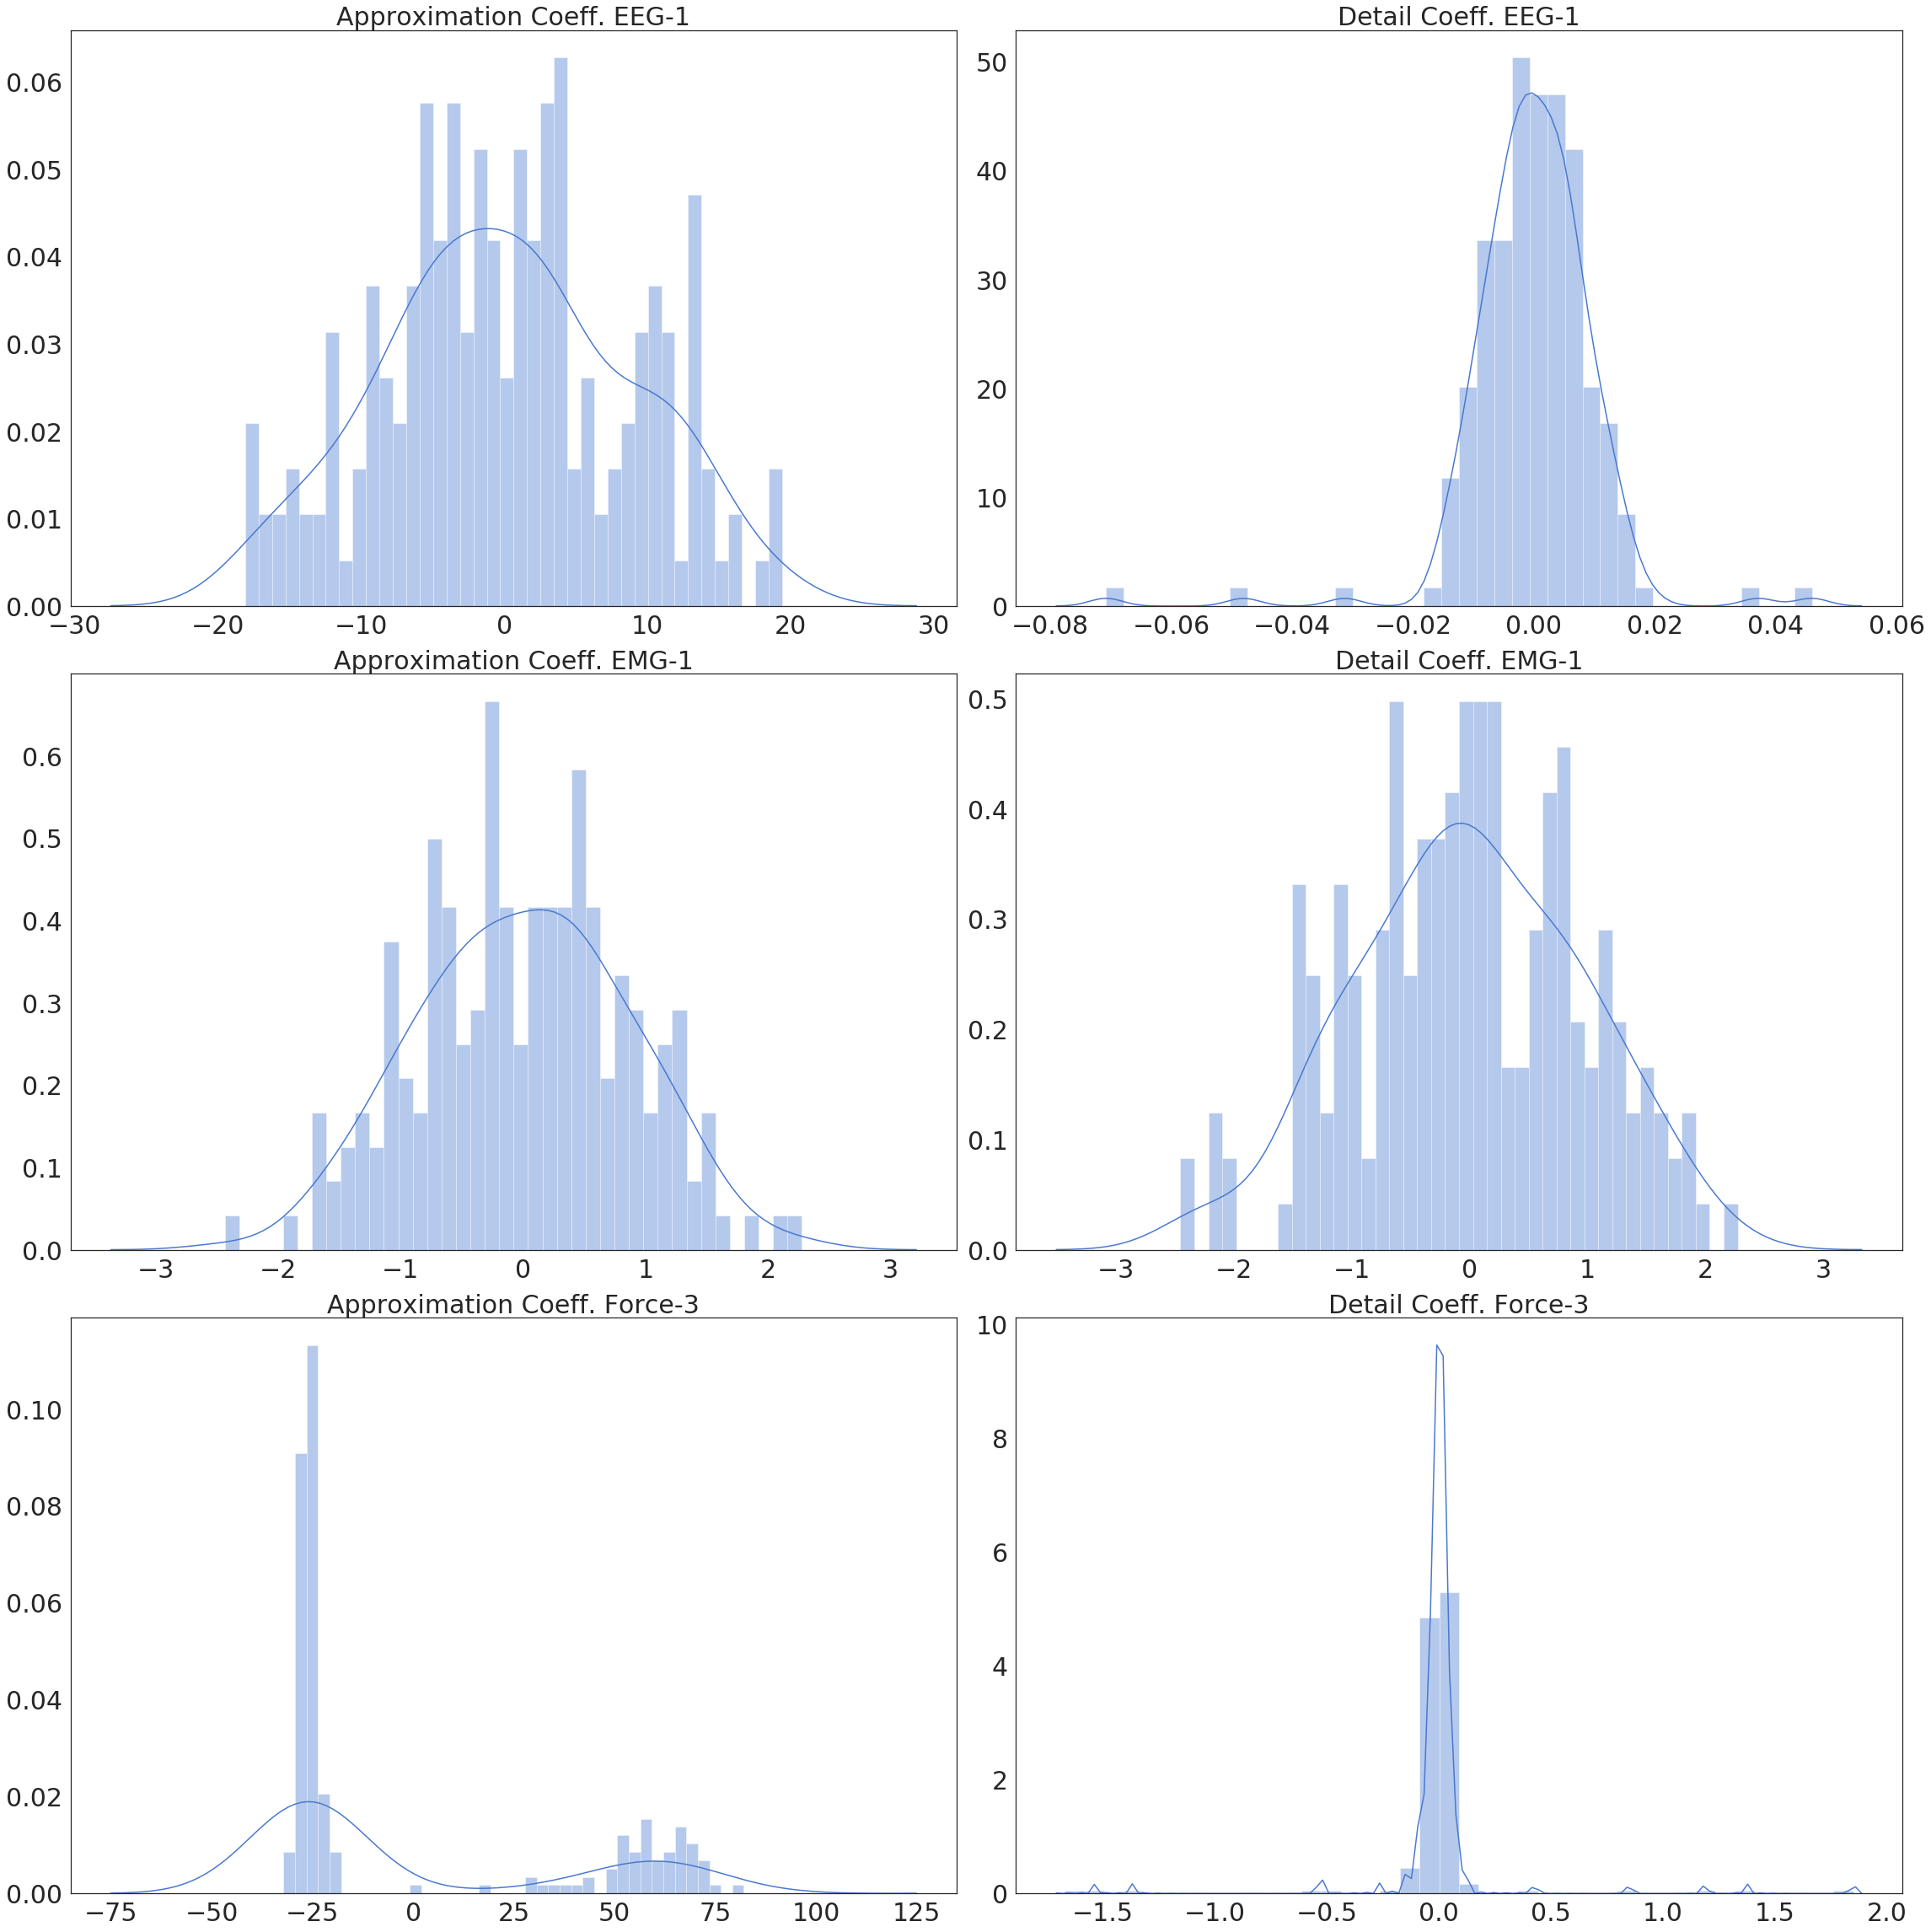

In [7]:
# cA: approximation coefficients (low frquency components)
# cD: detail coefficients (high frequency components)
(cA_eeg1, cD_eeg1) = pywt.dwt(eeg_signal_1, 'db4')
(cA_emg1, cD_emg1) = pywt.dwt(emg_signal_1, 'db4')
(cA_force3, cD_force3) = pywt.dwt(force_signal_3, 'db4')

list_of_coeffs = [cA_eeg1, cD_eeg1, cA_emg1, cD_emg1, cA_force3, cD_force3]

# Plot a histogram and kernel density estimate of wavelet coefficients
def hist_dwtCoeffs(list_of_coeffs):
    sns.set(style="white", palette="muted", color_codes=True)
    fig, axes = plt.subplots(3, 2, figsize=(32,32), sharex=False)
    for i, coeffs in enumerate(list_of_coeffs):
        sns.distplot(coeffs, bins=40, ax=axes[floor(i/2), i%2])
        axes[floor(i/2), i%2].tick_params(axis='both', which='major', labelsize=30)

    axes[0, 0].set_title('Approximation Coeff. EEG-1', fontsize=30) 
    axes[0, 1].set_title('Detail Coeff. EEG-1', fontsize=30)        
    axes[1, 0].set_title('Approximation Coeff. EMG-1', fontsize=30) 
    axes[1, 1].set_title('Detail Coeff. EMG-1', fontsize=30)    
    axes[2, 0].set_title('Approximation Coeff. Force-3', fontsize=30) 
    axes[2, 1].set_title('Detail Coeff. Force-3', fontsize=30)    

    plt.tight_layout()
    
hist_dwtCoeffs(list_of_coeffs)

# Parsimonity of Transform

### a) Reconstruction Without Compression

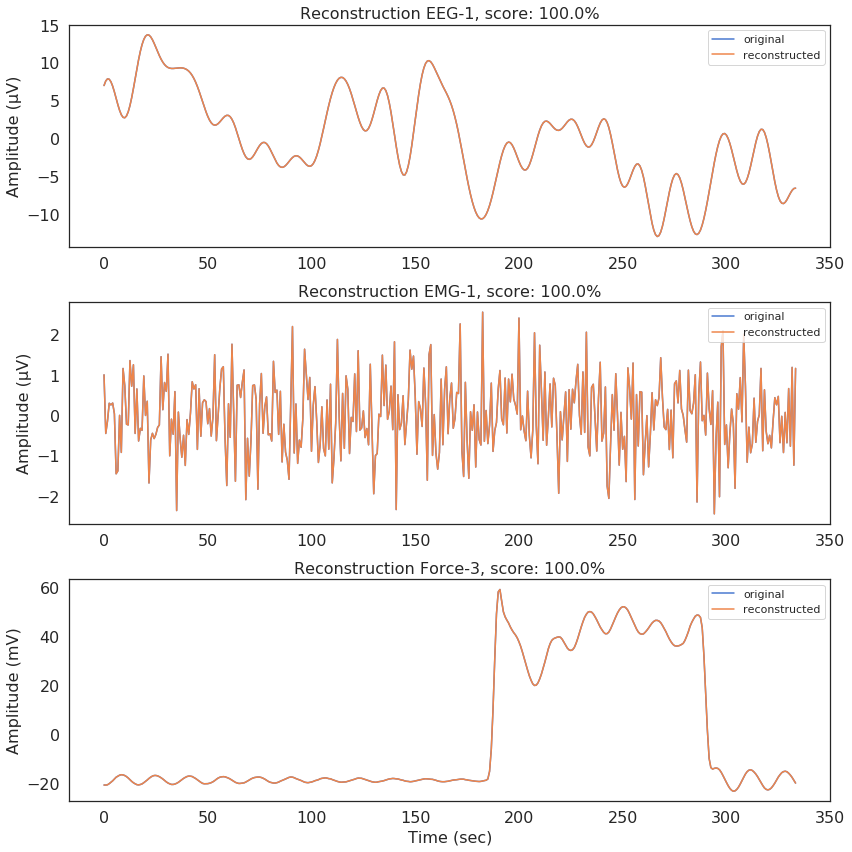

In [8]:
def get_reconstruction_score(original_sig, reconstructed_sig):
    return 100 * (norm(reconstructed_sig) ** 2 / norm(original_sig) ** 2)
    
scores = []
reconstructed_sigs = []
# Plot the reconstructed signals and show reconstruction scores
fig, axes = plt.subplots(3, figsize=(12,12), sharex=False)
for i, signal in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    axes[i].plot(time, signal, label='original')
    (cA, cD) = pywt.dwt(signal, 'db4')  
    reconstructed_sigs.append(pywt.idwt(cA, cD, 'db4'))  
    scores.append(get_reconstruction_score(signal, reconstructed_sigs[-1][:-1]))

for i, recon in enumerate(reconstructed_sigs):
    axes[i].plot(time, recon[:-1], label='reconstructed')
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    axes[i].legend(loc='upper right')
    
axes[0].set_title('Reconstruction EEG-1, score: %.1f' %scores[0]+'%', fontsize=16) 
axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_title('Reconstruction EMG-1, score: %.1f' %scores[1]+'%', fontsize=16)     
axes[1].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[2].set_title('Reconstruction Force-3, score: %.1f' %scores[2]+'%', fontsize=16) 
axes[2].set_ylabel('Amplitude (mV)', fontsize=16)
axes[2].set_xlabel('Time (sec)', fontsize=16)

plt.tight_layout()

### b) Wavelet Data Compression by Thresholding

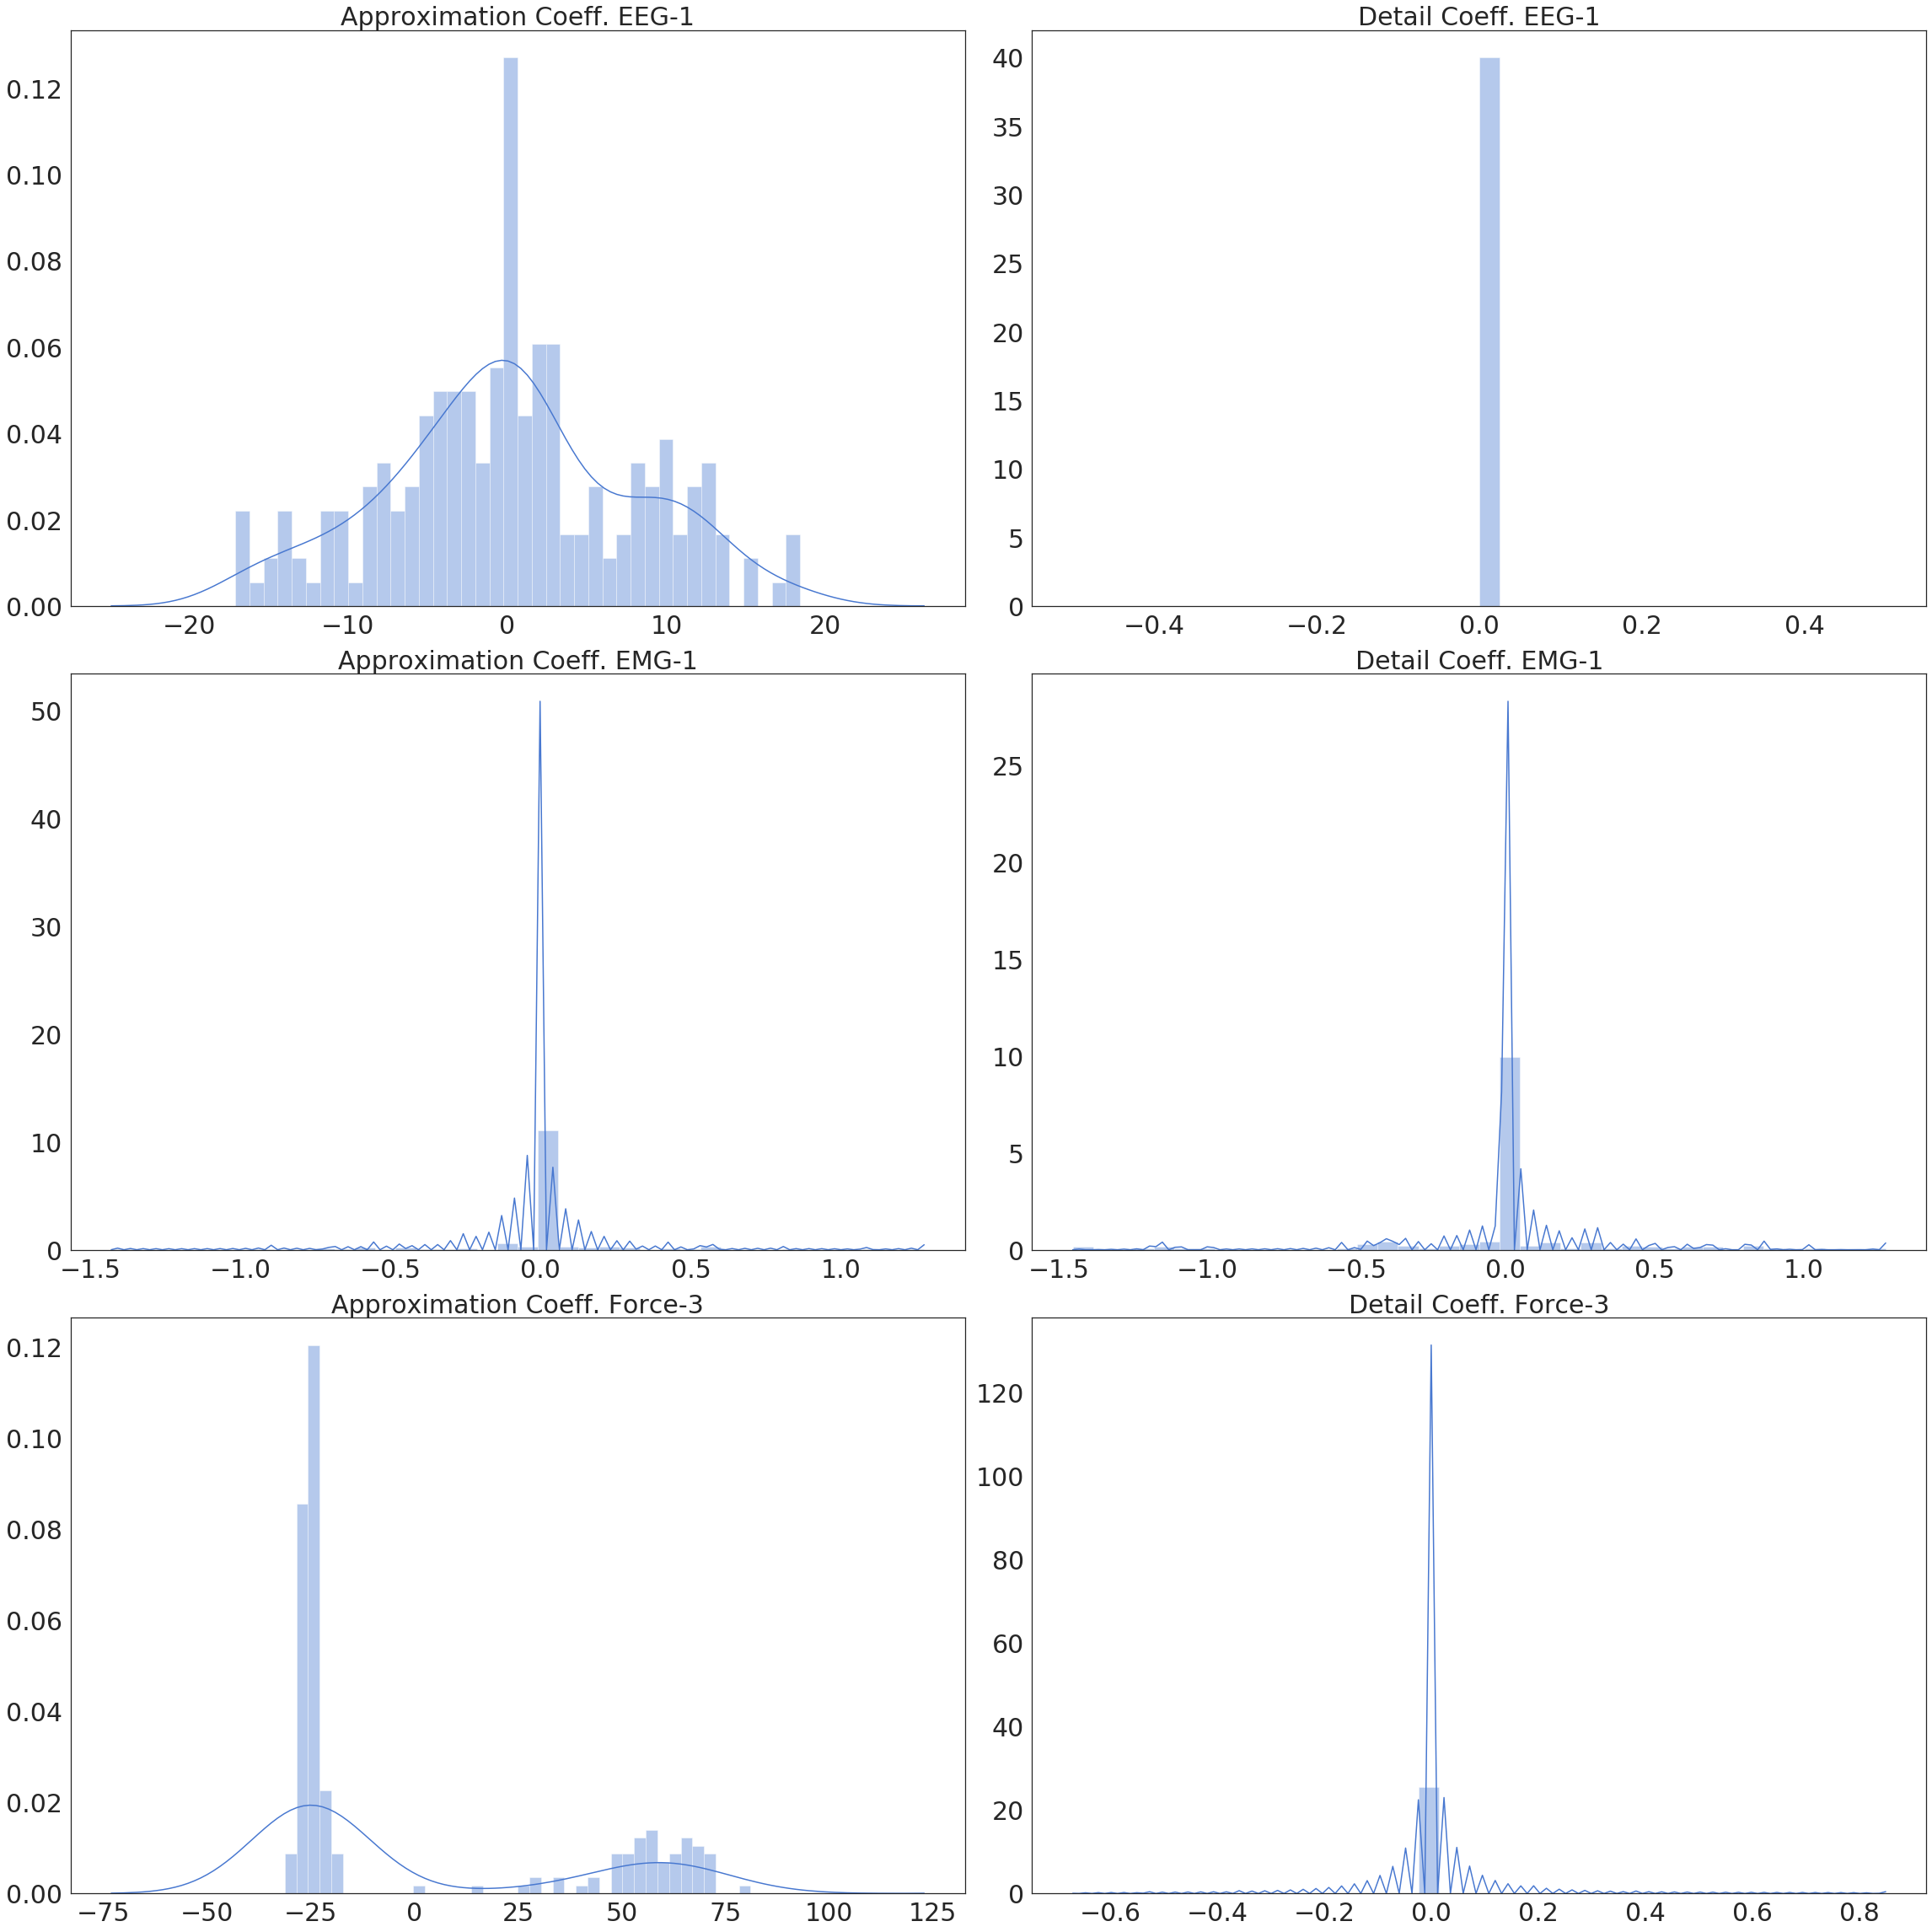

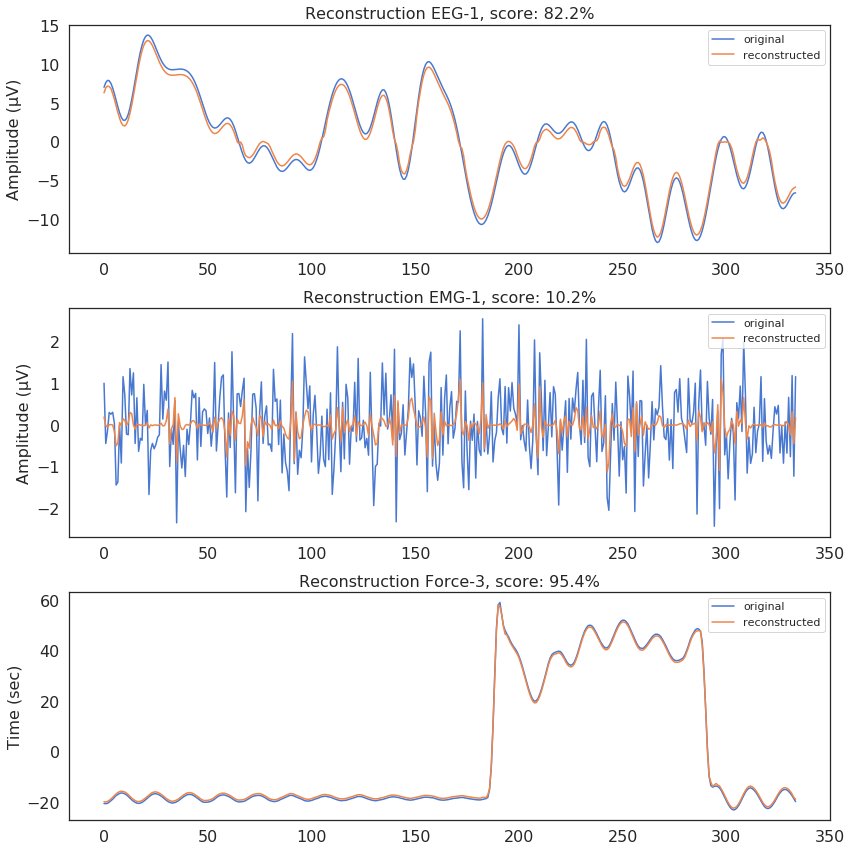

In [18]:
'''
Soft thresholding sets the wavelet coefficients with absolute value below the threshold to 0 and
other coefficients towards the origin by the magnitude of threshold.

Hard thresholding just sets the wavelet coefficients with absolute value below the threshold to 0.
'''
thresholded_list_of_coeffs = []

def threshold_coeffs(coeffs, threshold=1.0, soft=True):
    if soft == True:
        return [0 if abs(coef)<threshold else coef-np.sign(coef)*threshold for coef in coeffs]
    else:
        return [0 if abs(coef)<threshold else coef for coef in coeffs]

for coeffs in list_of_coeffs:
    thresholded_list_of_coeffs.append(threshold_coeffs(coeffs))

hist_dwtCoeffs(thresholded_list_of_coeffs)

# Plot the reconstructed signals and show reconstruction scores
scores, reconstructed_sigs = [], []
fig, axes = plt.subplots(3, figsize=(12,12), sharex=False)
for i, signal in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    axes[i].plot(time, signal, label='original')
    cA = thresholded_list_of_coeffs[2*i]
    cD = thresholded_list_of_coeffs[2*i+1]
    reconstructed_sigs.append(pywt.idwt(cA, cD, 'db4'))  
    scores.append(get_reconstruction_score(signal, reconstructed_sigs[-1][:-1]))

for i, recon in enumerate(reconstructed_sigs):
    axes[i].plot(time, recon[:-1], label='reconstructed')
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    axes[i].legend(loc='upper right')
    
axes[0].set_title('Reconstruction EEG-1, score: %.1f' %scores[0]+'%', fontsize=16) 
axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_title('Reconstruction EMG-1, score: %.1f' %scores[1]+'%', fontsize=16) 
axes[1].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[2].set_title('Reconstruction Force-3, score: %.1f' %scores[2]+'%', fontsize=16) 
axes[2].set_ylabel('Amplitude (mV)', fontsize=16)
axes[2].set_ylabel('Time (sec)', fontsize=16)

plt.tight_layout()

### c) Wavelet Data Compression by Parseval's Theorem

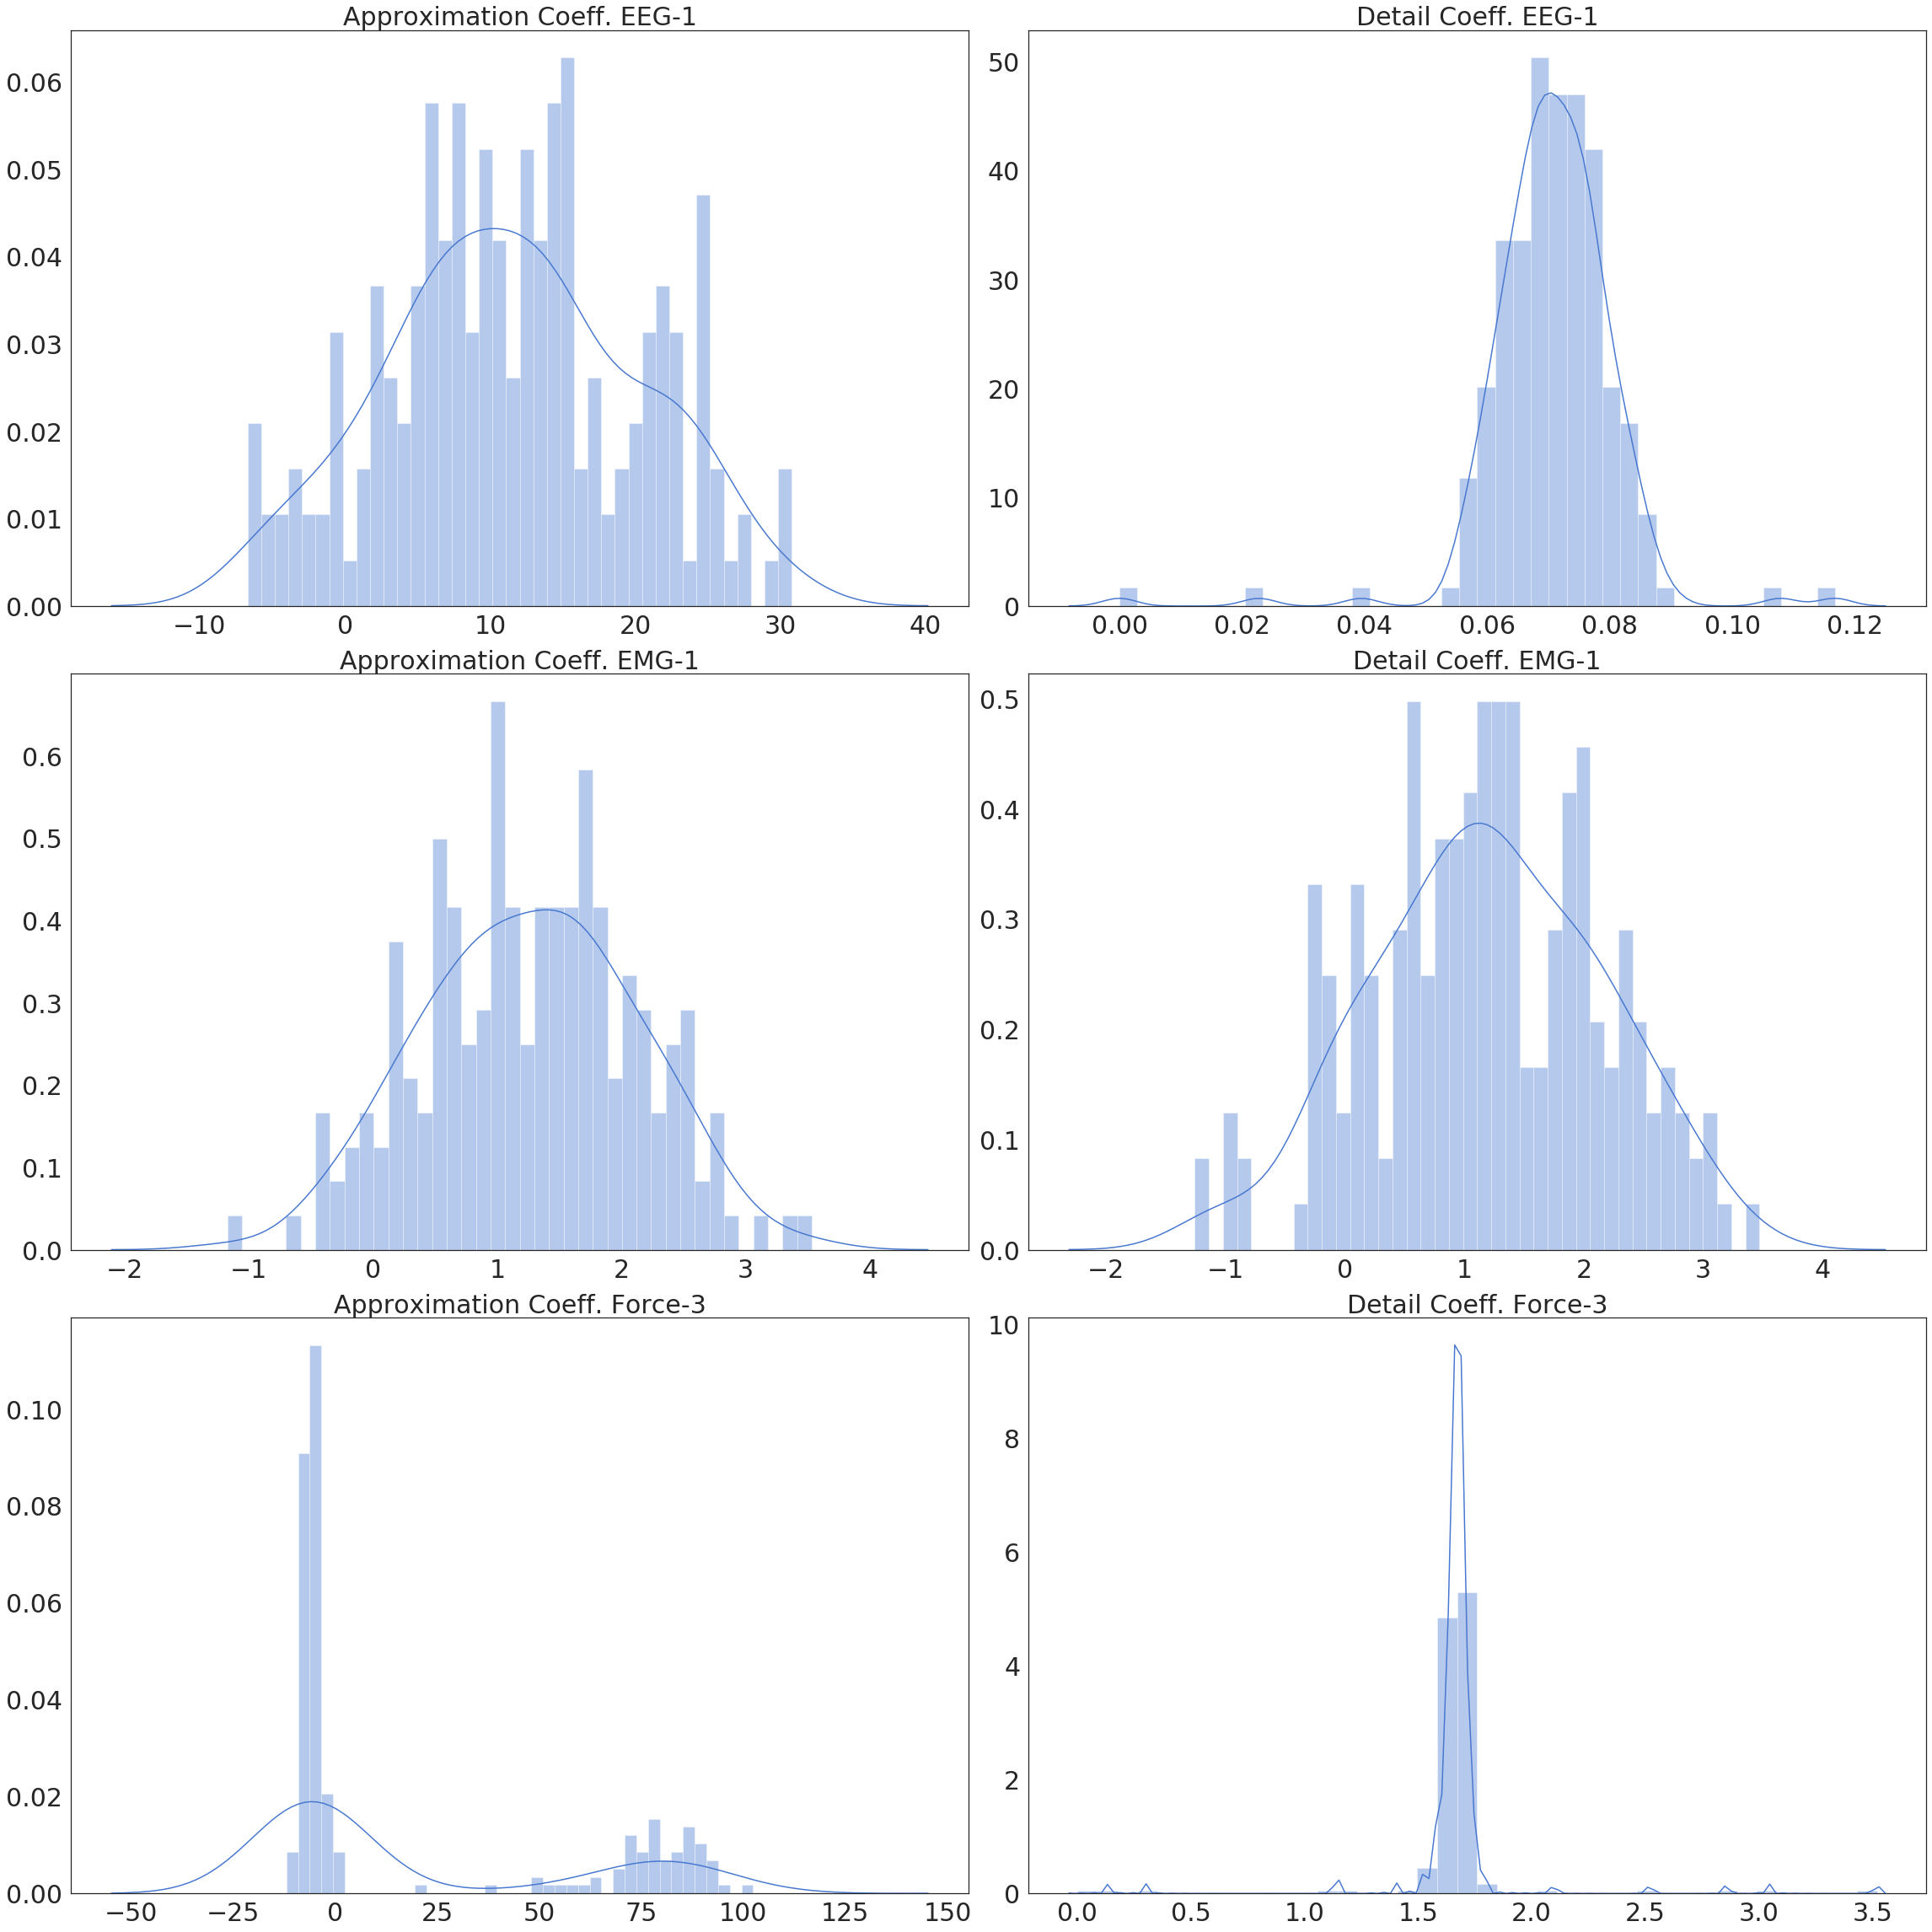

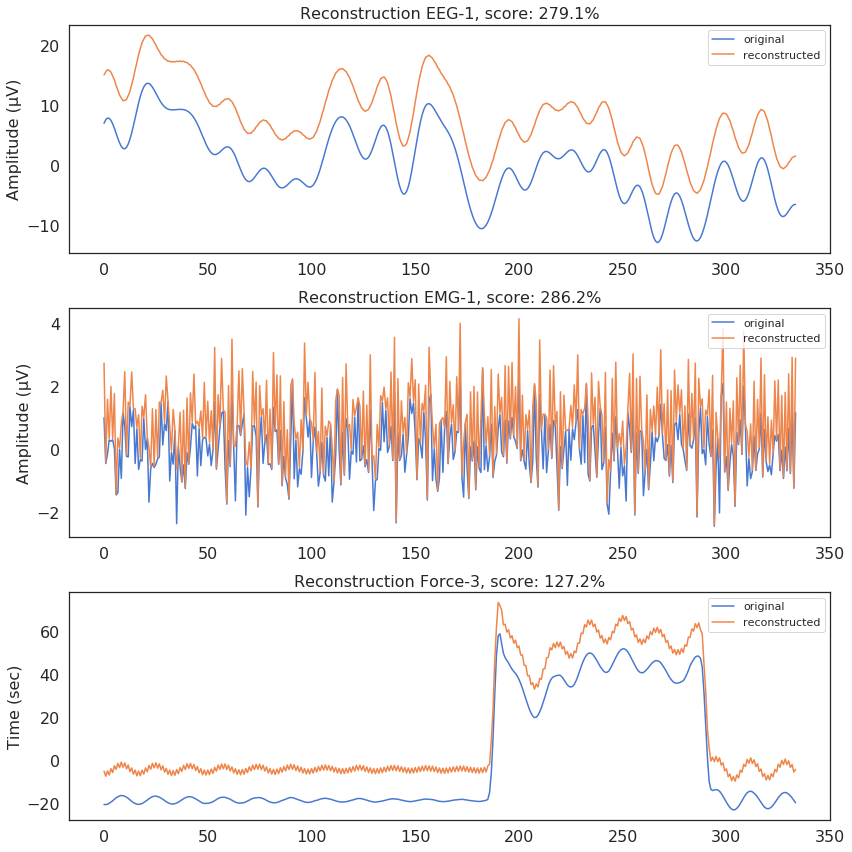

In [10]:
def retain_energy(cA, cD, original_signal, retained_ratio=0.70):
    energy = norm(original_signal) ** 2 # energy of the original signal
    sorted_cA = sorted(cA)[::-1] # dwt coeffs sorted in a decreasing order
    sorted_cD = sorted(cD)[::-1]
    sum, i, j = 0, 0, 0 
    # evaluate the energy of the compressed signal until a certain amount of energy 
    # from the original signal is retained.
    while sum < int(energy * retained_ratio):
        if sorted_cA[i] >= sorted_cD[j]: 
            if i+1 < len(sorted_cA):
                sum += sorted_cA[i] ** 2
                i += 1
            else:
                sum += sorted_cD[j] ** 2
                j += 1         
        if sorted_cA[i] < sorted_cD[j]: 
            if j+1 < len(sorted_cD):
                sum += sorted_cD[j] ** 2
                j += 1
            else:
                sum += sorted_cA[i] ** 2
                i += 1
    cA = threshold_coeffs(cA, threshold=sorted_cA[i])
    cD = threshold_coeffs(cD, threshold=sorted_cD[j])
    return cA, cD
    
retained_list_of_coeffs = []

# split the list of coefficients into [cA, cD] for each signal
split_list = [list_of_coeffs[i:i+2] for i in range(0, len(list_of_coeffs), 2)]
for coeffs, signal in zip(split_list, [eeg_signal_1, emg_signal_1, force_signal_3]):
    retained_list_of_coeffs.append(retain_energy(coeffs[0], coeffs[1], signal)[0])
    retained_list_of_coeffs.append(retain_energy(coeffs[0], coeffs[1], signal)[1])

hist_dwtCoeffs(retained_list_of_coeffs)

# Plot the reconstructed signals and show reconstruction scores
scores, reconstructed_sigs = [], []
fig, axes = plt.subplots(3, figsize=(12,12), sharex=False)
for i, signal in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    axes[i].plot(time, signal, label='original')
    cA = retained_list_of_coeffs[2*i]
    cD = retained_list_of_coeffs[2*i+1]
    reconstructed_sigs.append(pywt.idwt(cA, cD, 'db4'))  
    scores.append(get_reconstruction_score(signal, reconstructed_sigs[-1][:-1]))

for i, recon in enumerate(reconstructed_sigs):
    axes[i].plot(time, recon[:-1], label='reconstructed')
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    axes[i].legend(loc='upper right')
    
axes[0].set_title('Reconstruction EEG-1, score: %.1f' %scores[0]+'%', fontsize=16) 
axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_title('Reconstruction EMG-1, score: %.1f' %scores[1]+'%', fontsize=16) 
axes[1].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[2].set_title('Reconstruction Force-3, score: %.1f' %scores[2]+'%', fontsize=16) 
axes[2].set_ylabel('Amplitude (mV)', fontsize=16)
axes[2].set_ylabel('Time (sec)', fontsize=16)

plt.tight_layout()


# Vector Auto-Regression Based on DWT Coefficients

# Continuous Wavelet Transform and Scaleograms

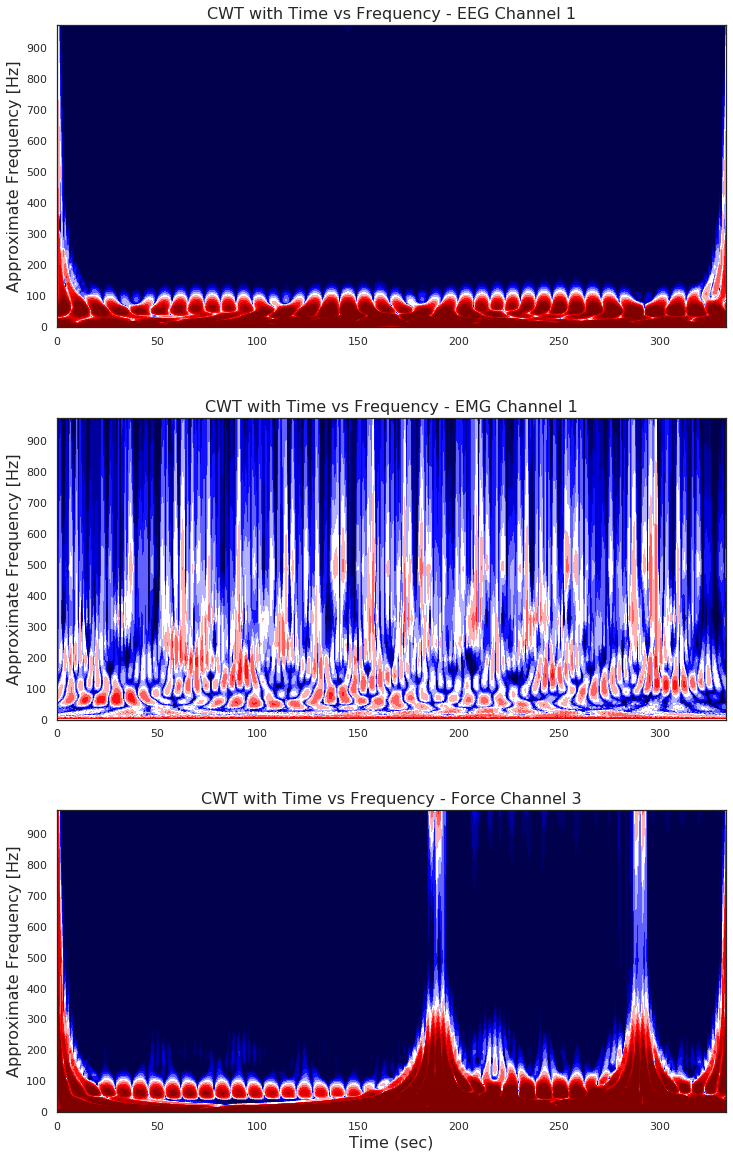

In [11]:
scales = np.arange(1,num_samples_per_trial+1)
wavelet_type = 'morl'
fig, axes = plt.subplots(3, figsize=(12,20))
fig.subplots_adjust(hspace=0.3)
for i, signal in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    coef_matrix, freqs = pywt.cwt(signal, scales, wavelet_type, sampling_period=dt)
    power = (abs(coef_matrix)) ** 2
    levels = [0.0078125, 0.015625 ,0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]
    contourlevels = np.log2(levels)
    im = axes[i].contourf(time, freqs, np.log2(power), contourlevels, 
                          extend='both',cmap=plt.cm.seismic)
    #axes[i].matshow(coef_matrix) 
    axes[i].set_ylabel('Approximate Frequency [Hz]', fontsize=16)
    axes[i].set_xlim(time.min(), time.max())
    if i == 0:
        axes[i].set_title('CWT with Time vs Frequency - EEG Channel 1', fontsize=16)
    elif i == 1:
        axes[i].set_title('CWT with Time vs Frequency - EMG Channel 1', fontsize=16)
    else:
        axes[i].set_title('CWT with Time vs Frequency - Force Channel 3', fontsize=16)
        axes[i].set_xlabel('Time (sec)', fontsize=16)
    yticks = np.arange(0, round(freqs.max()/100)*100, step=100)
    axes[i].set_yticks(yticks)

plt.show()